# Football Game Predictor 

## 1. Data cleaning and initial exploration 

### Libaries import & csv file reading

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import time

with open("epl-training.csv") as training_set:
    df = pd.read_csv(training_set, skipinitialspace=True)

### Check the initial features

In [112]:
df = df.dropna(axis = 1)
# drop empty columns
print(df.keys())
# number of teams and referees 
print(len(set(df.HomeTeam)))
print(len(set(df.Referee)))

Index(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC',
       'HY', 'AY', 'HR', 'AR'],
      dtype='object')
36
36


### Examine whether there are any trivial patterns

Home win time: 1931
Away win time: 1212
Draw time: 1037
Home win rate: 0.4619617224880383
number of home team wins: [83, 190, 176, 172, 181, 166, 175, 163, 175, 188, 172, 90]
number of away team wins: [65, 94, 89, 104, 109, 111, 120, 122, 108, 115, 117, 58]
number of draws: [50, 94, 109, 101, 101, 95, 85, 95, 95, 98, 82, 32]


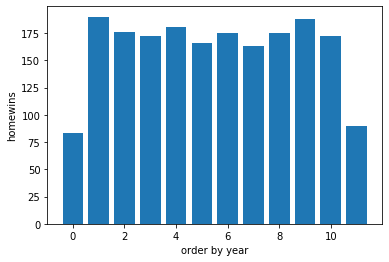

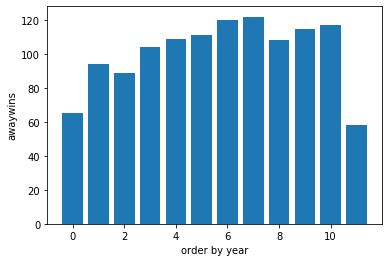

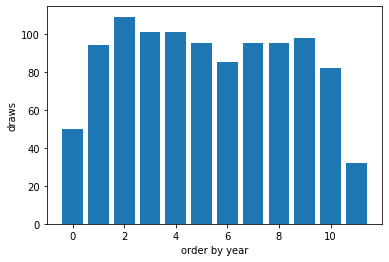

In [113]:
def checkWins(df, start_index, end_index):
    hw = 0
    aw = 0
    d = 0
    for i in range(start_index, end_index):
        if df.FTR[i] == 'H':
            hw += 1
        elif df.FTR[i] == 'A':
            aw += 1
        elif df.FTR[i] == 'D':
            d += 1
    return hw, aw, d

homewins, awaywins, draws = checkWins(df, 0, len(df.Date))
print("Home win time: " + str(homewins))
print("Away win time: " + str(awaywins))   
print("Draw time: " + str(draws))    
print("Home win rate: " + str(homewins/4180))
print("=====================================")
# The statistics show that it is more likely that home team wins.

year_index = [0, 4180]
i = 0
while i < len(df.Date):
    for j in range(i, len(df.Date)):
        if df.Date[j][-2:] != df.Date[i][-2:]:
            year_index.append(j)
            i = j
            break
    i += 1

year_index.sort()


homewin_byyear = []
awaywin_byyear = []
draw_byyear = []
for i in range(0, len(year_index)-1):
    hw, aw, d = checkWins(df, year_index[i], year_index[i+1])
    homewin_byyear.append(hw)
    awaywin_byyear.append(aw)
    draw_byyear.append(d)


print("number of home team wins: " + str(homewin_byyear))
print("number of away team wins: " + str(awaywin_byyear))
print("number of draws: " + str(draw_byyear))

plt.bar(range(0, 12), homewin_byyear)
plt.ylabel('homewins')
plt.xlabel('order by year')
plt.show()


plt.bar(range(0, 12), awaywin_byyear)
plt.ylabel('awaywins')
plt.xlabel('order by year')
plt.show()


plt.bar(range(0, 12), draw_byyear)
plt.ylabel('draws')
plt.xlabel('order by year')
plt.show()


Initial data ends at "12/05/2019", which means we only have about half of all games in 2019.\
It can be observed that the home wins, away wins and draws are fairly consistent, \
which means there is less randomness in our learning model.


## 2. Feature Engineering

### Features to be created:

#### the time from last game

In [114]:
def timeParser(i, df):
    time = df.Date[i]
    if len(str(time)) < 10:
        time_obj = datetime.datetime.strptime(str(time)[0:6] + '20' + str(time)[6:], '%d/%m/%Y')
    else:
        time_obj = datetime.datetime.strptime(str(time), '%d/%m/%Y')
    return time_obj


def getLastGameTime(i, df):
    hteam = df.HomeTeam[i]
    ateam = df.AwayTeam[i]
    time_obj = timeParser(i, df)
    th = 0
    ta = 0
    for j in range(1, i):
        temp = i-j
        if df.HomeTeam[temp] == hteam or df.AwayTeam[temp] == hteam:
            hteam_lt = timeParser(i-j, df)
            th = (time_obj - hteam_lt).days
            break
    for j in range(1, i):
        if df.HomeTeam[i-j] == ateam or df.AwayTeam[i-j] == ateam:
            ateam_lt = timeParser(i-j, df)
            ta = (time_obj - ateam_lt).days
            break
    if th == 0:
        th = 7
    if ta == 0:
        ta = 7
            
    return th, ta

lastgame_home = []
lastgame_away = []

for i in range(0, len(df.Date)):
    t1, t2 = getLastGameTime(i, df)
    lastgame_home.append(t1)
    lastgame_away.append(t2)

Calculate the time between current match and last match.\
The consideration is that if a football team gets enough but not too long resting time they tend to play better.

#### The Elo ranking value

In [115]:
def getEloRanking(df):
    csv_dict = df.to_dict(orient='list')
    home_team = csv_dict['HomeTeam']
    away_team = csv_dict['AwayTeam']
    Ftr = csv_dict['FTR']

    #find the number of teams in the league:
    num_team = []
    for i in range(len(home_team)):
        if home_team[i] not in num_team:
            num_team.append(home_team[i])
    #total number of 36 team.
    
    #initialise elo rating 
    ratings = np.ones(len(num_team))*1500
    elo_ratings = dict(zip(num_team,ratings))
    #Home Advantage initially guess 100
    HA = 100
    #G is the margin parameters needs to be calculated through 
    #the difference

    #parameters setting for K 
    K = 20

    #parameters setting for G
    def G_calculator(Home_goal,Away_goal):
        if abs(Home_goal-Away_goal) == 1:
            G = 1
        elif abs(Home_goal-Away_goal) == 0:
            G = 1
        elif abs(Home_goal-Away_goal) == 2:
            G = 1.5
        else:
            G = (11+abs(Home_goal-Away_goal))/8
        return G

    #create home and away elo rating list, for training
    home_elo = []
    away_elo = []
    sum_elo = 0
    for i in range(len(home_team)):
        home = home_team[i]
        away = away_team[i]
        dr = elo_ratings[home] - elo_ratings[away] + HA 
        home_elo.append(elo_ratings[home])
        away_elo.append(elo_ratings[away])
        
        # account for home advantage
        E = 1/(1+10**(-dr/400))
        H = csv_dict['HTHG'][i]
        A = csv_dict['HTAG'][i]
        G = G_calculator(H,A)
        if csv_dict['FTR'][i] == 'H':
            O = 1
        elif csv_dict['FTR'][i] == 'D':
            O = 0.5
        elif csv_dict['FTR'][i] == 'A':
            O = 0
        delta_elo = K*G*(O-E)
        
        #update elo ratings
        elo_ratings[home] = elo_ratings[home] + delta_elo
        elo_ratings[away] = elo_ratings[away] - delta_elo
        
        #update home advantage parameters
        sum_elo = sum_elo + delta_elo
        HA = HA + sum_elo*0.075
    return home_elo , away_elo 

h_elo, a_elo = getEloRanking(df)

#### Stats from previous 10 games
##### Shot Number, Goal Difference, Shot on Target

In [116]:
def getPastStats(i, df):

    hteam = df.HomeTeam[i]
    ateam = df.AwayTeam[i]
    shots_home = 0
    shots_away = 0
    goaldif_home = 0
    goaldif_away = 0
    
    
    # Calculate the number of shots for both away team and home team
    j = i
    k = i
    h_count = 0
    a_count = 0
    while h_count < 10 or a_count < 10:
        j -= 1
        if j <= 0:
            break

        if h_count < 10:
            
            if df.HomeTeam[j] == hteam:
                shots_home += df.HS[j]
                goaldif_home += (df.FTHG[j] - df.FTAG[j])
                h_count += 1
            elif df.AwayTeam[j] == hteam:
                shots_home += df.AS[j]
                goaldif_home += (df.FTAG[j] - df.FTHG[j])
                h_count += 1

        if a_count < 10:
            if df.HomeTeam[j] == ateam:
                shots_away += df.HS[j]
                goaldif_away += (df.FTHG[j] - df.FTAG[j])
                a_count += 1
            elif df.AwayTeam[j] == ateam:
                shots_away += df.AS[j]
                goaldif_away += (df.FTAG[j] - df.FTHG[j])
                a_count += 1
            
    return shots_home, shots_away, goaldif_home, goaldif_away


pastshots_home = []
pastshots_away = []
pastgoaldif_home = []
pastgoaldif_away = []

# start = time.process_time()

for i in range(0, len(df.Date)):
    s1, s2, d1, d2 = getPastStats(i, df)
    if s1 == 0:
        s1 = 121
    if s2 == 0:
        s2 = 121
    pastshots_home.append(s1)
    pastgoaldif_home.append(d1)
    pastshots_away.append(s2)
    pastgoaldif_away.append(d2)

# print(time.process_time() - start)

In [117]:
# Merge the result into dataframe
df['HomeElo'] = h_elo
df['AwayElo'] = a_elo
df['LastGame_home'] = lastgame_home
df['LastGame_away'] = lastgame_away
df['PastShot_home'] = pastshots_home
df['PastShot_away'] = pastshots_away
df['PastGoaldiff_home'] = pastgoaldif_home
df['PastGoaldiff_away'] = pastgoaldif_away
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HR,AR,HomeElo,AwayElo,LastGame_home,LastGame_away,PastShot_home,PastShot_away,PastGoaldiff_home,PastGoaldiff_away
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,12/05/2019,Liverpool,Wolves,2,0,H,1,0,H,M Atkinson,...,0,0,1959.280362,1486.147038,8,8,163,119,21,2
4176,12/05/2019,Man United,Cardiff,0,2,A,0,1,A,J Moss,...,0,0,1842.236237,1360.530352,7,8,132,108,-4,-10
4177,12/05/2019,Southampton,Huddersfield,1,1,D,1,0,H,L Probert,...,0,0,1532.821220,1335.246319,8,7,120,101,-2,-18
4178,12/05/2019,Tottenham,Everton,2,2,D,1,0,H,A Marriner,...,0,0,1851.345457,1630.570634,8,9,158,146,0,11


### Dropping features

In [118]:
# Dropping referee and date.
test_format = df
df = df.drop(['Referee', 'Date', 'FTR', 'HTR', 'FTHG', 'HTHG', 'FTAG', 'HTAG'], axis = 'columns')
df

,HomeTeam,AwayTeam,HS,AS,HST,AST,HF,AF,HC,AC,...,HR,AR,HomeElo,AwayElo,LastGame_home,LastGame_away,PastShot_home,PastShot_away,PastGoaldiff_home,PastGoaldiff_away
0,Arsenal,West Brom,24,5,14,4,11,8,7,5,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
1,Bolton,Stoke,14,8,8,2,13,12,4,3,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
2,Everton,Blackburn,10,15,5,11,11,9,3,5,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
3,Hull,Fulham,11,12,6,6,10,9,5,6,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
4,Middlesbrough,Tottenham,14,8,10,5,11,12,7,9,...,0,0,1500.000000,1500.000000,7,7,121,121,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,Liverpool,Wolves,13,7,5,2,3,11,4,1,...,0,0,1959.280362,1486.147038,8,8,163,119,21,2
4176,Man United,Cardiff,26,13,10,4,9,6,11,2,...,0,0,1842.236237,1360.530352,7,8,132,108,-4,-10
4177,Southampton,Huddersfield,10,10,3,3,8,6,4,3,...,0,0,1532.821220,1335.246319,8,7,120,101,-2,-18
4178,Tottenham,Everton,11,17,3,9,10,13,7,4,...,0,0,1851.345457,1630.570634,8,9,158,146,0,11


### Get dummy variables for categorical features

In [119]:
# create dummy variables --
h_dummies = pd.get_dummies('h_' + df.HomeTeam)
a_dummies = pd.get_dummies('a_' + df.AwayTeam)
df = df.drop(['HomeTeam', 'AwayTeam'], axis = 'columns')
df.to_csv('processed.csv')
df

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HomeElo,AwayElo,LastGame_home,LastGame_away,PastShot_home,PastShot_away,PastGoaldiff_home,PastGoaldiff_away
0,24,5,14,4,11,8,7,5,0,0,0,0,1500.000000,1500.000000,7,7,121,121,0,0
1,14,8,8,2,13,12,4,3,1,2,0,0,1500.000000,1500.000000,7,7,121,121,0,0
2,10,15,5,11,11,9,3,5,2,2,0,0,1500.000000,1500.000000,7,7,121,121,0,0
3,11,12,6,6,10,9,5,6,3,0,0,0,1500.000000,1500.000000,7,7,121,121,0,0
4,14,8,10,5,11,12,7,9,1,2,0,0,1500.000000,1500.000000,7,7,121,121,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4175,13,7,5,2,3,11,4,1,0,2,0,0,1959.280362,1486.147038,8,8,163,119,21,2
4176,26,13,10,4,9,6,11,2,3,3,0,0,1842.236237,1360.530352,7,8,132,108,-4,-10
4177,10,10,3,3,8,6,4,3,0,1,0,0,1532.821220,1335.246319,8,7,120,101,-2,-18
4178,11,17,3,9,10,13,7,4,0,2,0,0,1851.345457,1630.570634,8,9,158,146,0,11


### Plot heat map to check correlations between features

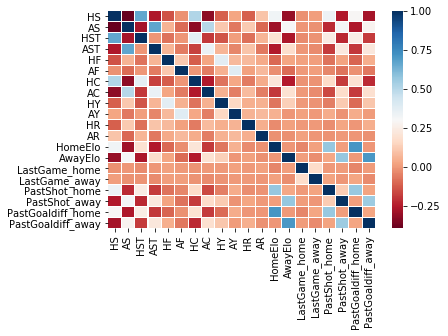

In [120]:
colormap = plt.cm.RdBu
ax = sns.heatmap(df.astype(float).corr(),linewidths=0.01,vmax=1.0
            , cmap=colormap)

By analysing this heat map, we can see that there are some features strongly correlated to others.\
For example, AST and AS\
We hope to eliminate the linear correlations in order to achieve the best training outcome.\

#### Principle Component Analysis

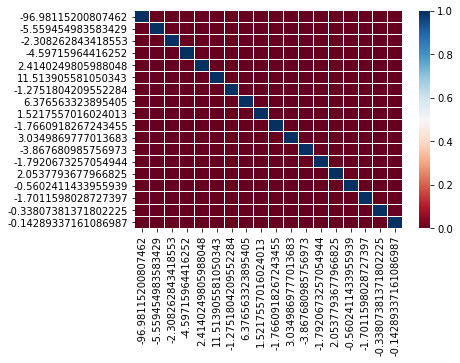

In [152]:
from sklearn import decomposition

with open("processed.csv") as processed_set:
    processed = pd.read_csv(processed_set, skipinitialspace=True)
    processed = processed.drop("Unnamed: 0", axis = "columns")

pca = decomposition.PCA(n_components='mle', copy='true')
pca_data = pca.fit_transform(processed)
processed = pca_data



newdf = pd.DataFrame(data=pca_data[1:,1:], index=pca_data[1:,0], columns=pca_data[0,1:]) 
colormap = plt.cm.RdBu
ax = sns.heatmap(newdf.astype(float).corr(),linewidths=0.01,vmax=1.0
            , cmap=colormap)


### Normalisation

In [153]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Divide the data into feature values and label values
data_x = processed
data_y = test_format.FTR

# Specify data that's only available after the match
insufficient_features = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 
                      'HY', 'AY', 'HR', 'AR']

x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,test_size=0.3, random_state=0)

# Set the specified features to be 0 in the test data.
# for col in insufficient_features:
#     x_test[col].values[:] = 0

# Standardise data 
x_train = preprocessing.scale(x_train)

x_test

array([[-6.42105712e+01, -1.36193864e+02, -5.27372198e+00, ...,
         1.50141495e-02,  9.94917289e-01, -6.75497910e-02],
       [-2.16248714e+01, -3.00637315e+02, -6.45225577e+00, ...,
         5.26878699e-01, -1.79608317e+00, -1.00069403e-01],
       [ 1.86904632e+02, -8.37085615e+01, -4.69348309e+00, ...,
         1.48339201e+00, -1.08772252e+00, -6.26634335e-03],
       ...,
       [-3.07918944e+02,  5.75054989e+01, -3.70064654e+00, ...,
        -2.14495555e+00,  1.89856218e+00, -4.51404508e-02],
       [-4.04411439e+02,  2.45910552e+02, -1.11215716e+00, ...,
         1.37928353e+00,  9.76544957e-01, -7.71839051e-02],
       [ 5.19553284e+01, -1.51990496e+02, -5.62155140e+00, ...,
         9.91605553e-01,  6.83760588e-01, -1.49825440e-01]])

# Logistic Regression on training data 

In [154]:
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.metrics import f1_score    
""" 
    Using the approach of logistic regression
    Taking all current game stats be 0, while keep past information(shots, elo ranking)
    All data normalised and standardised
"""

def train_classifier(clf, x_train, y_train):
    start = time()
    clf.fit(x_train, y_train)
    end = time()
    print("Training time {:}".format(end - start))
    
def predict_labels(clf, features, target):
    y_pred = clf.predict(features)
    return f1_score(target, y_pred, pos_label=1, average='macro'), sum(target 
                                                      == y_pred) / float(len(y_pred))

def train_predict(clf, x_train, y_train, x_test, y_test):
    
    # Indicate the classifier and the training set size
    print("Training..")
    train_classifier(clf, x_train, y_train)
    f1, acc = predict_labels(clf, x_test, y_test)
    print("==================================")
    print("Result on the testing set")
    print("F1 score value: " + str(f1))
    print("Precision value: " + str(acc))
    
    f1, acc = predict_labels(clf, x_train, y_train)

    print("\nResult on the training set")
    print("F1 score value: " + str(f1))
    print("Precision value: " + str(acc))
    

    
clf_A = LogisticRegression(multi_class='multinomial', class_weight='balanced', C=0.001)
train_predict(clf_A, x_train, y_train, x_test, y_test)

Training..
Training time 0.022616863250732422
Result on the testing set
F1 score value: 0.47032191973477344
Precision value: 0.5023923444976076

Result on the training set
F1 score value: 0.5309369187891212
Precision value: 0.5628844839371155


# Neural network on training data